In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis
from InterruptedTimeSeries import ITS, MITS

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <a id='toc1_'></a>[中断時系列分析をする](#toc0_)

## <a id='toc1_1_'></a>[データ準備](#toc0_)

正味コロナデータの準備もクラスに入れたい

In [39]:
game_df = pd.read_csv('./data/monthly_average_game_time.csv')
game_df =game_df.set_index('Unnamed: 0').rename_axis('Date').reset_index()
# game_dfのdateを変換
game_df['Date'] = pd.to_datetime(game_df['Date'], format='%Y/%m/1')
# 日付はいらない。月だけでいい
game_df['Date'] = game_df['Date'].dt.strftime('%Y-%m')

# game_df.set_index('date', inplace=True)
# game_df.index.name = None
game_df['Date'] = pd.to_datetime(game_df['Date'], format='%Y-%m')

game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 54 non-null     datetime64[ns]
 1   Game Time (minutes)  54 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 996.0 bytes


In [2]:
# コロナのデータを確認
covid_new_cases_df = pd.read_csv('./data/new_cases.csv')
covid_new_death_df = pd.read_csv('./data/new_deaths.csv')
# 年-月の形式に変換
covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y/%m/%d')
covid_new_death_df['Date'] = pd.to_datetime(covid_new_death_df['Date'], format='%Y/%m/%d')
# Dateをindexに設定
covid_new_cases_df.set_index('Date', inplace=True)
covid_new_death_df.set_index('Date', inplace=True)
# 年-月の形式に変換
# covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y-%m')

covid_new_cases_df.reset_index(inplace=True)
covid_new_death_df.reset_index(inplace=True)

In [33]:
covid_new_cases_df

,Date,new_cases
0,2013-04-01,0
1,2013-05-01,0
2,2013-06-01,0
3,2013-07-01,0
4,2013-08-01,0
...,...,...
61,2023-05-01,170425
62,2023-06-01,0
63,2023-07-01,0
64,2023-08-01,0


In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier='with_predict')
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(game_df)
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(covid_new_cases_df)
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(covid_new_death_df) #? コロナデータ入れない方が良いかも。。。

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29988D+01    |proj g|=  2.06281D+00

At iterate    5    f=  1.23400D+01    |proj g|=  1.28532D-01

At iterate   10    f=  1.22608D+01    |proj g|=  9.35530D-02

At iterate   15    f=  1.22243D+01    |proj g|=  1.57222D-01

At iterate   20    f=  1.22021D+01    |proj g|=  1.08947D-01

At iterate   25    f=  1.22013D+01    |proj g|=  6.39626D-03

At iterate   30    f=  1.22006D+01    |proj g|=  1.02883D-01

At iterate   35    f=  1.21992D+01    |proj g|=  2.35841D-02

At iterate   40    f=  1.21986D+01    |proj g|=  7.89498D-03

At iterate   45    f=  1.21969D+01    |proj g|=  6.38762D-03

At iterate   50    f=  1.21951D+01    |proj g|=  1.73677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## <a id='toc1_2_'></a>[分析](#toc0_)

In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier='with_predict')
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()

its_periodical_OLS = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='State Space Model')
its_periodical_OLS.show_summary()

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29988D+01    |proj g|=  2.06281D+00

At iterate    5    f=  1.23400D+01    |proj g|=  1.28532D-01

At iterate   10    f=  1.22608D+01    |proj g|=  9.35530D-02

At iterate   15    f=  1.22243D+01    |proj g|=  1.57222D-01

At iterate   20    f=  1.22021D+01    |proj g|=  1.08947D-01

At iterate   25    f=  1.22013D+01    |proj g|=  6.39626D-03

At iterate   30    f=  1.22006D+01    |proj g|=  1.02883D-01

At iterate   35    f=  1.21992D+01    |proj g|=  2.35841D-02

At iterate   40    f=  1.21986D+01    |proj g|=  7.89498D-03

At iterate   45    f=  1.21969D+01    |proj g|=  6.38762D-03

At iterate   50    f=  1.21951D+01    |proj g|=  1.73677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:1024: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  endog=self.df_its['Attendance']-self.df_its['Attendance'][0], # 観客者数
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmod

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:             Attendance   No. Observations:                   54
Model:             local linear trend   Log Likelihood                -718.562
                        + seasonal(6)   AIC                           1451.123
Date:                Mon, 18 Dec 2023   BIC                           1464.074
Time:                        00:47:12   HQIC                          1455.997
Sample:                             0                                         
                                 - 54                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular       4.833e+11   2.95e+11      1.641      0.101    -9.4e+10    1.06e+12
sigma2.level           4.866e+09   6.05e+11      0.008      0.994   -1.18e+12    1.19e+12
sigma2.trend           1.004e+11   1.52e+11      0.660      0.509   -1.98e+11    3.98e+11
beta.time since start    96.0717   3.28e+06   2.92e-05      1.000   -6.44e+06    6.44e+06
beta.level change 0   -5.147e+05    1.9e+06     -0.271      0.787   -4.24e+06    3.21e+06
beta.slope change 0    1.932e+05   1.32e+06      0.147      0.883   -2.38e+06    2.77e+06
beta.pulse1           -1.359e+06   1.28e+06     -1.062      0.288   -3.87e+06    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                14.25
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.77
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33067D+01    |proj g|=  4.60964D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   4.610D-07   1.331D+01
  F =   13.306698675242133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:1071: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df_its["Attendance"]-self.df_its['Attendance'][0], label="Observations")


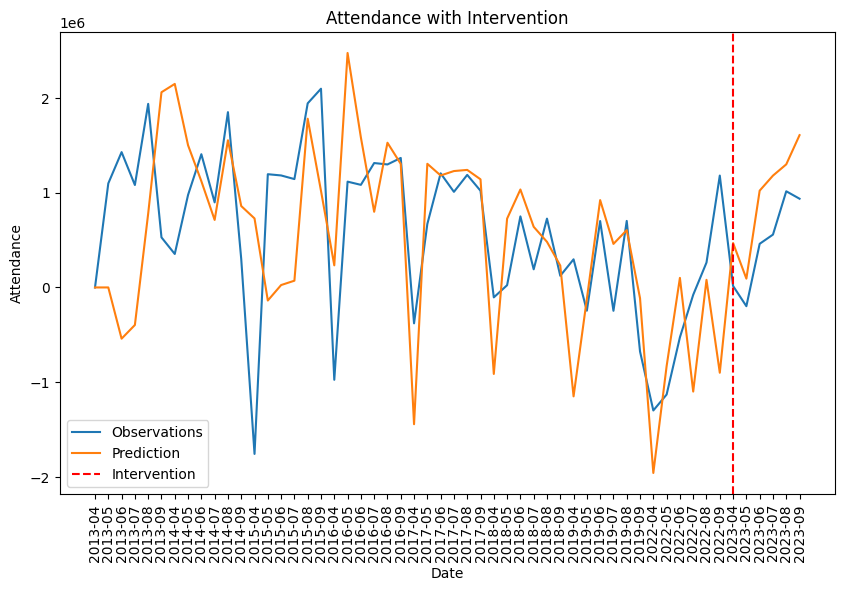

In [3]:
its_periodical_OLS.plot_state_space_model()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:865: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:866: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridd

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34864D+01    |proj g|=  5.47650D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      0      1      0     0     0   5.476D-07   1.349D+01
  F =   13.486425112280582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


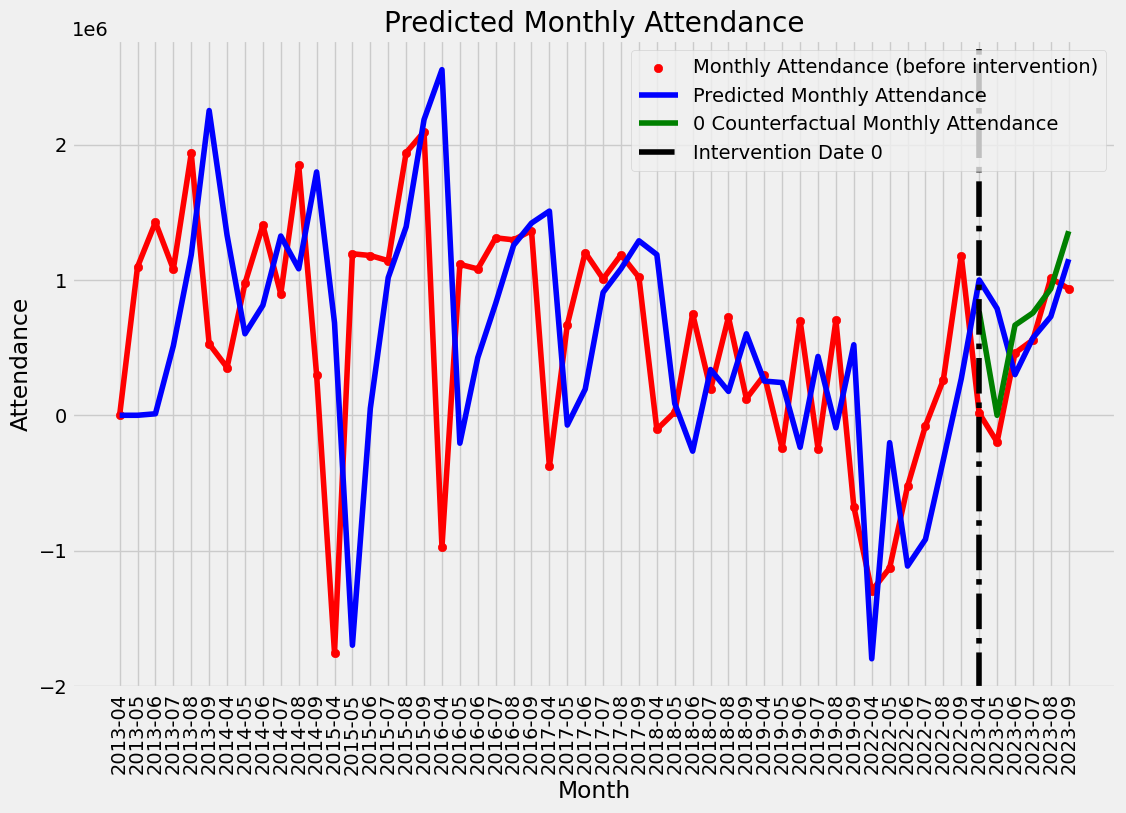

In [3]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True)
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()
its_periodical_OLS = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=False, seed=7)
its_periodical_OLS.show_summary()
# its_periodical_OLS.plot_predict(is_counterfactual=True)

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:708: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/version

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(0, 2, 3)x(0, 2, 3, 6)   Log Likelihood                -612.948
Date:                           Sun, 17 Dec 2023   AIC                           1247.895
Time:                                   19:32:09   BIC                           1266.473
Sample:                                        0   HQIC                          1254.613
                                            - 54                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0 -4.101e+06   5.03e+05     -8.160      0.000   -5.09e+06   -3.12e+06
slope change 0 -1.435e+06   9.84e+05     -1.458      0.145   -3.36e+06    4.94e+05
pulse          -3.182e+06   1.36e+06     -2.344      0.019   -5.84e+06   -5.22e+05
pulse2         -4.799e+05   8.41e+05     -0.571      0.568   -2.13e+06    1.17e+06
ma.L1             -1.0054      0.420     -2.391      0.017      -1.830      -0.181
ma.L2              0.4132      0.452      0.914      0.361      -0.473       1.299
ma.L3             -0.2182      0.334     -0.653      0.514      -0.874       0.437
ma.S.L6           -0.7518      0.416     -1.807      0.071      -1.567       0.064
ma.S.L12           0.0948      0.492      0.193      0.847      -0.869       1.059
ma.S.L18          -0.0128      0.588     -0.022      0.983      -1.165       1.139
sigma2          1.531e+12      0.829   1.85e+12      0.000    1.53e+12    1.53e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.82
Prob(Q):                              0.92   Prob(JB):                         0.02
Heteroskedasticity (H):               1.32   Skew:                             1.04
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+28. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:865: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:866: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28717D+01    |proj g|=  2.36778D-01

At iterate    5    f=  1.28392D+01    |proj g|=  1.00405D-02

At iterate   10    f=  1.28368D+01    |proj g|=  2.95091D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     12     14      1     0     0   1.207D-05   1.284D+01
  F =   12.836817815178222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


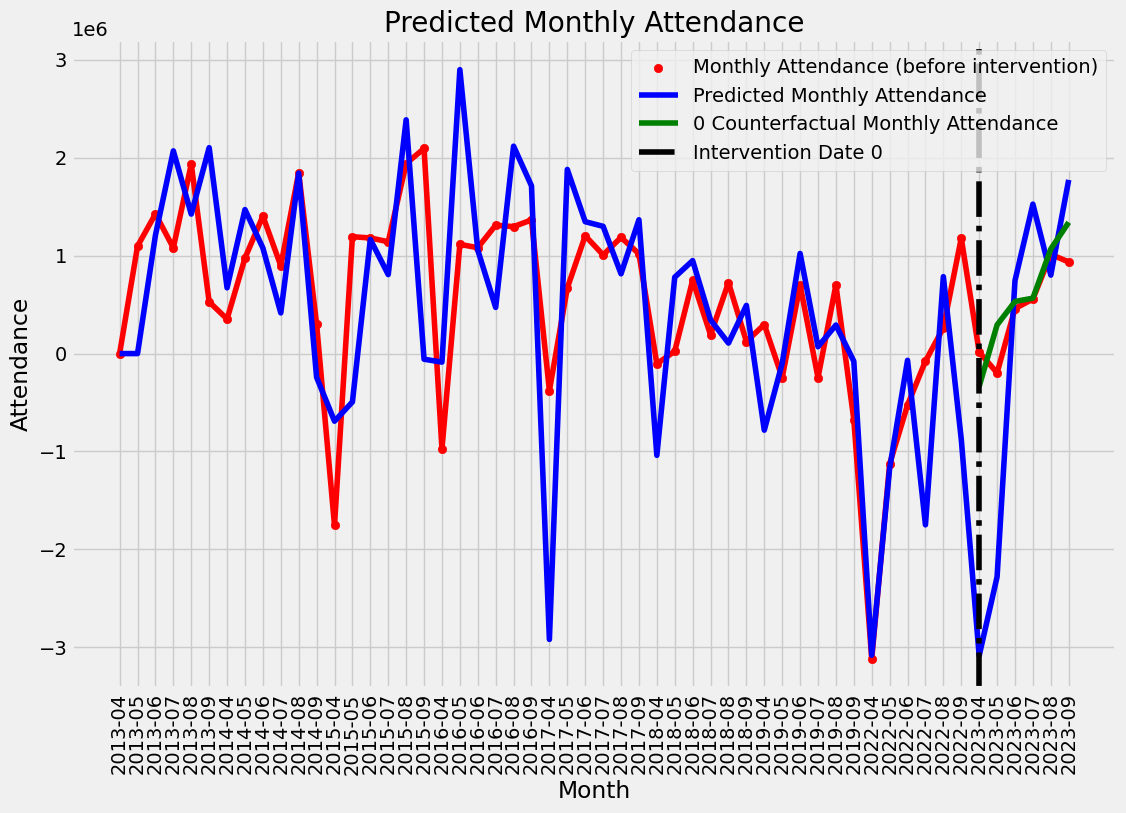

In [3]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

## SARIMAXで中断時系列分析


In [46]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7)

In [47]:
its_sarimax.show_summary()

seed値:7


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal m

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 6)   Log Likelihood                -711.857
Date:                           Mon, 13 Nov 2023   AIC                           1447.713
Time:                                   11:42:53   BIC                           1469.915
Sample:                                        0   HQIC                          1456.068
                                            - 54                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Game Time (minutes)   1.61e+04   3.97e+04      0.405      0.685   -6.18e+04     9.4e+04
time since start    -1.695e-05   8502.124  -1.99e-09      1.000   -1.67e+04    1.67e+04
level change 0       2.282e+06    169.133   1.35e+04      0.000    2.28e+06    2.28e+06
slope change 0       -7.14e+05    660.390  -1081.134      0.000   -7.15e+05   -7.13e+05
ar.L1                  -0.8340      0.527     -1.583      0.113      -1.866       0.198
ma.L1                   0.6601      0.530      1.246      0.213      -0.378       1.699
ma.L2                  -0.0645      0.203     -0.317      0.751      -0.463       0.334
ar.S.L6                -0.2649      0.718     -0.369      0.712      -1.672       1.142
ar.S.L12                0.7271      0.380      1.914      0.056      -0.018       1.472
ma.S.L6                -0.0142      1.500     -0.009      0.992      -2.955       2.927
ma.S.L12               -0.9857      0.648     -1.521      0.128      -2.256       0.284
sigma2               8.125e+11   6.67e-07   1.22e+18      0.000    8.12e+11    8.12e+11
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.07   Prob(JB):                         0.32
Heteroskedasticity (H):               1.37   Skew:                            -0.19
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+37. Standard errors may be unstable.
"""

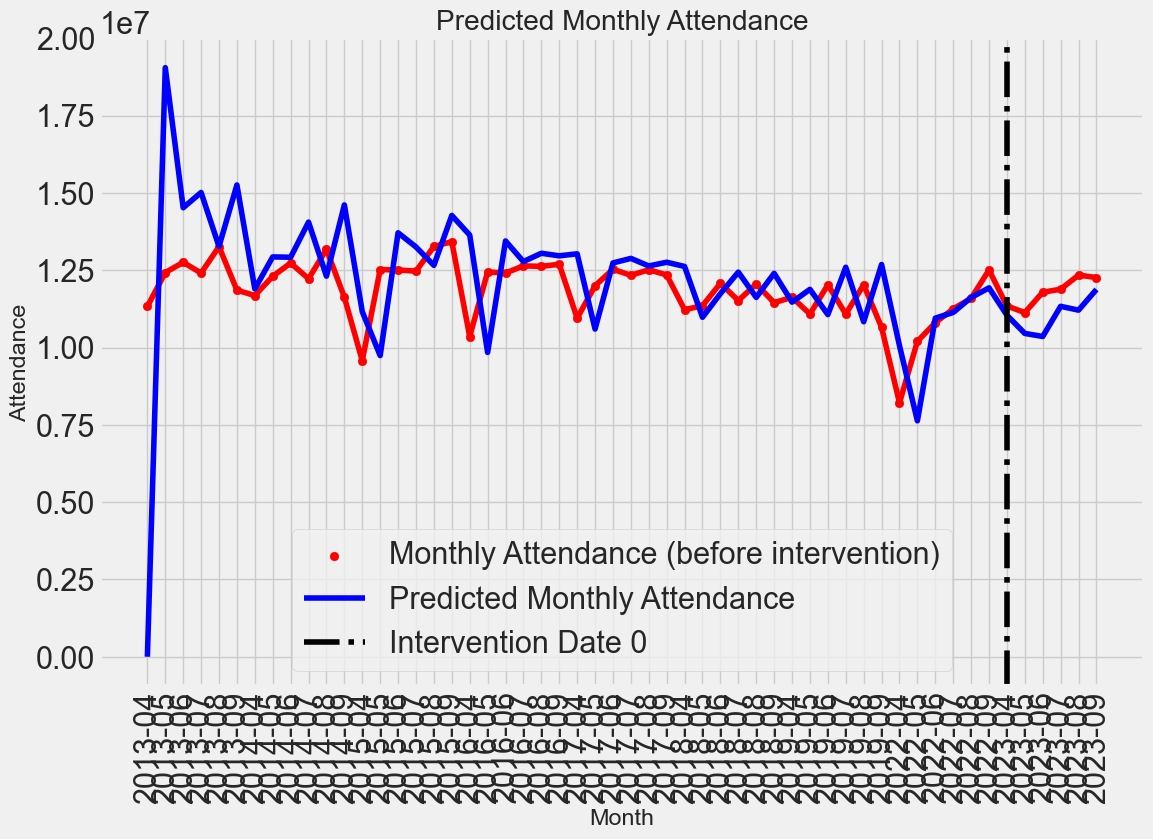

In [44]:
its_sarimax.plot_predict()

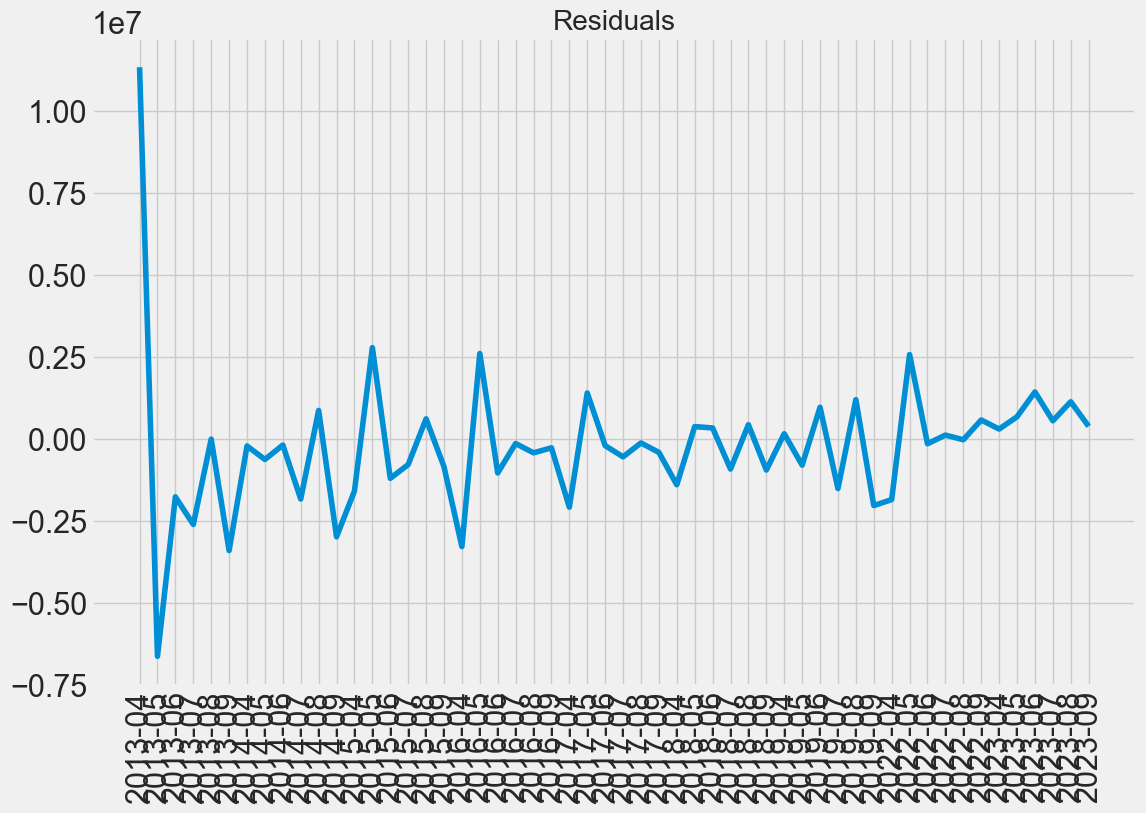

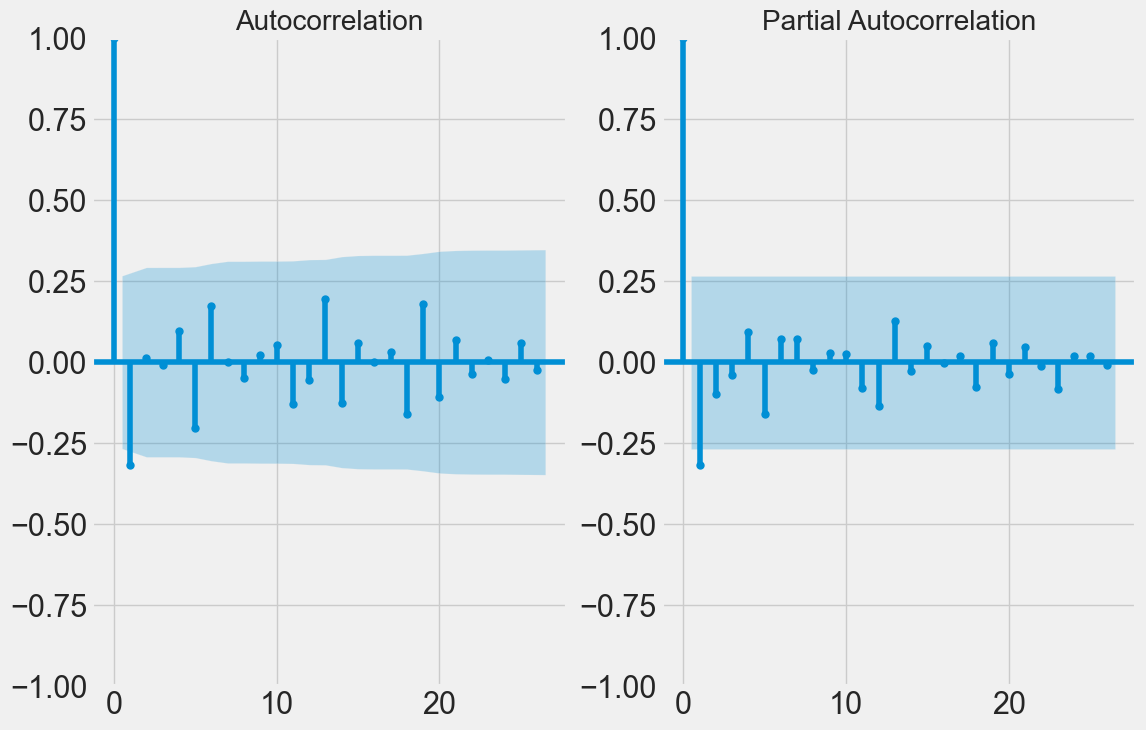

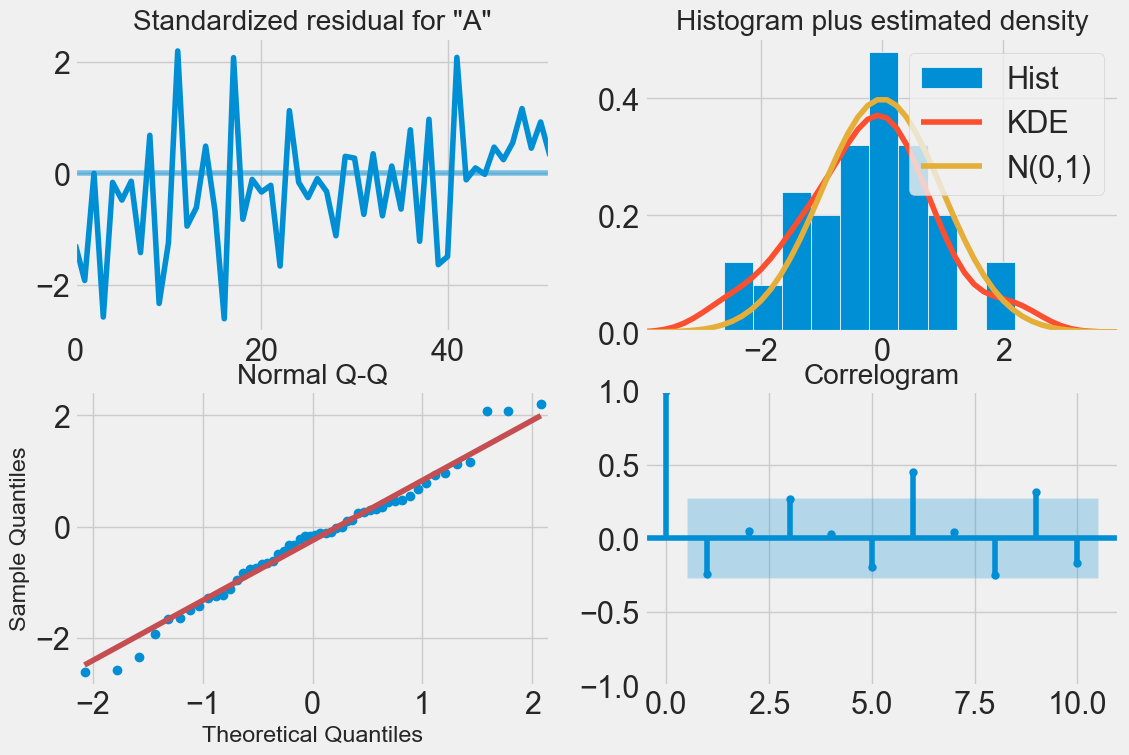

In [45]:
its_sarimax.plot_sarimax_params()

## ARIMAXで中断時系列分析

In [48]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='ARIMAX', optim_params_arimax=True)
its_sarimax.show_summary()

seed値:0


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                   54
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -806.902
Date:                Mon, 13 Nov 2023   AIC                           1631.803
Time:                        11:58:37   BIC                           1649.365
Sample:                             0   HQIC                          1638.536
                                 - 54                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Game Time (minutes)   1.74e+04   1.94e+04      0.899      0.369   -2.05e+04    5.53e+04
time since start       -0.0032   2.16e+04  -1.49e-07      1.000   -4.23e+04    4.23e+04
level change 0      -4.805e+05   8.52e+04     -5.639      0.000   -6.47e+05   -3.13e+05
slope change 0      -1.217e+06   7.99e+05     -1.522      0.128   -2.78e+06     3.5e+05
ar.L1                  -0.7718      0.168     -4.604      0.000      -1.100      -0.443
ar.L2                   0.1550      0.184      0.842      0.400      -0.206       0.516
ma.L1                2.781e-05    182.684   1.52e-07      1.000    -358.054     358.054
ma.L2                  -1.0000      0.228     -4.383      0.000      -1.447      -0.553
sigma2               1.351e+12   1.03e-09   1.31e+21      0.000    1.35e+12    1.35e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.22   Prob(JB):                         0.88
Heteroskedasticity (H):               0.46   Skew:                            -0.17
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+45. Standard errors may be unstable.
"""

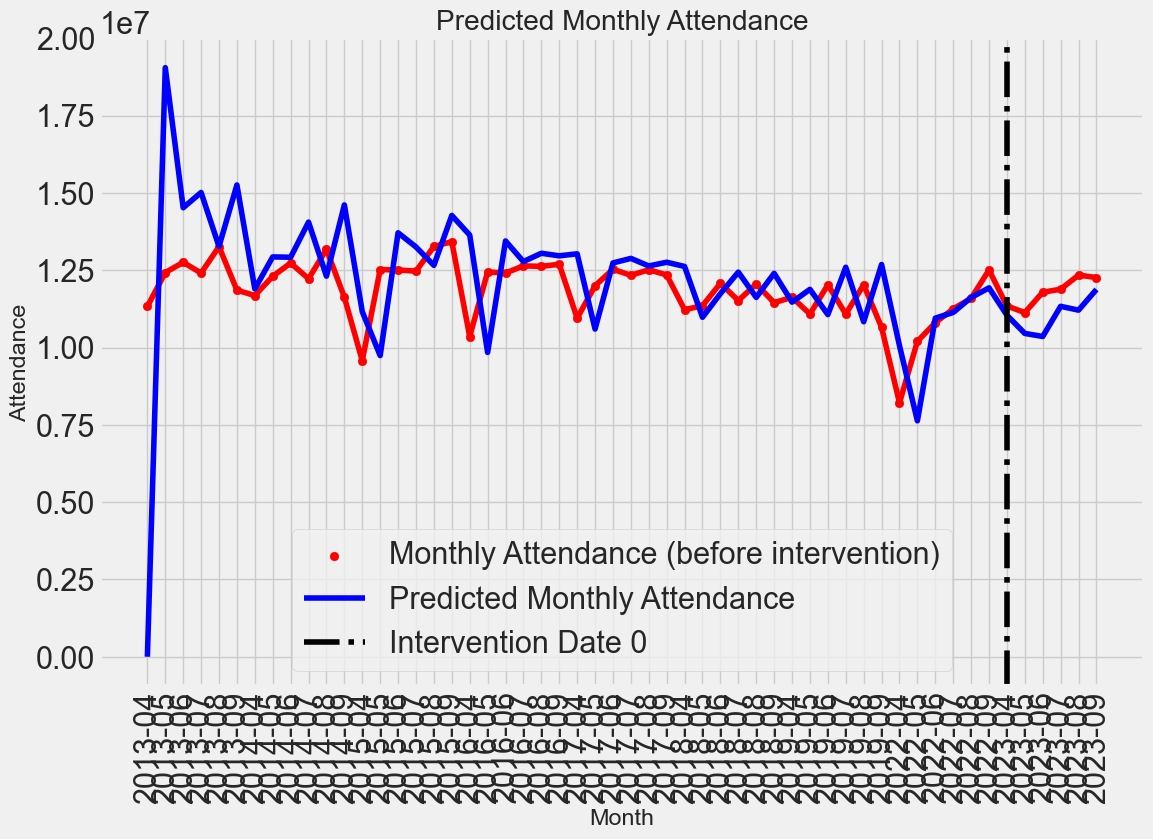

In [47]:
its_sarimax.plot_predict()


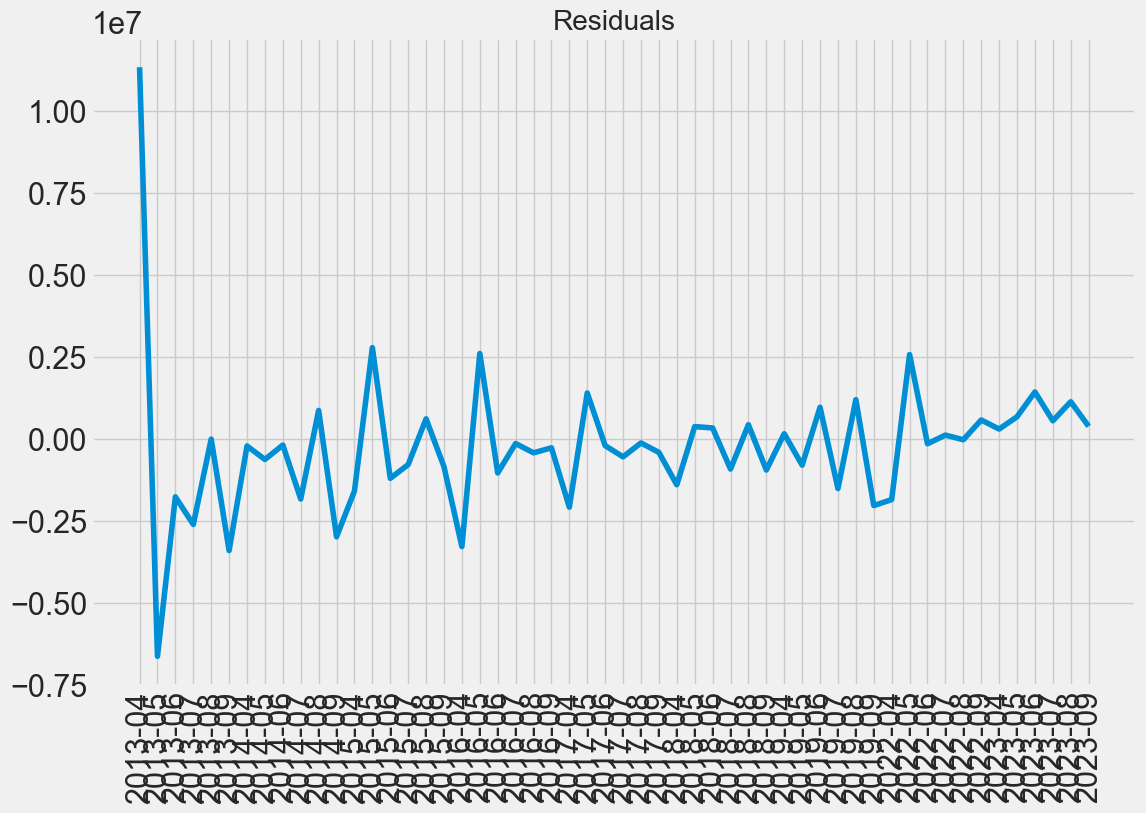

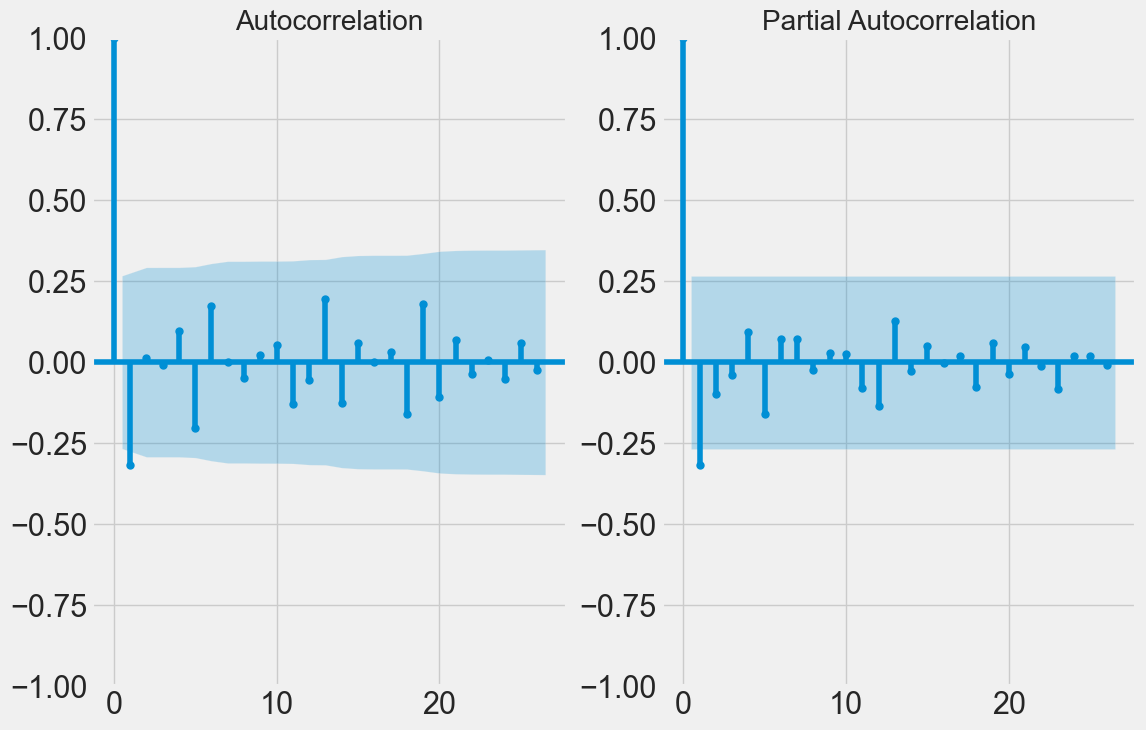

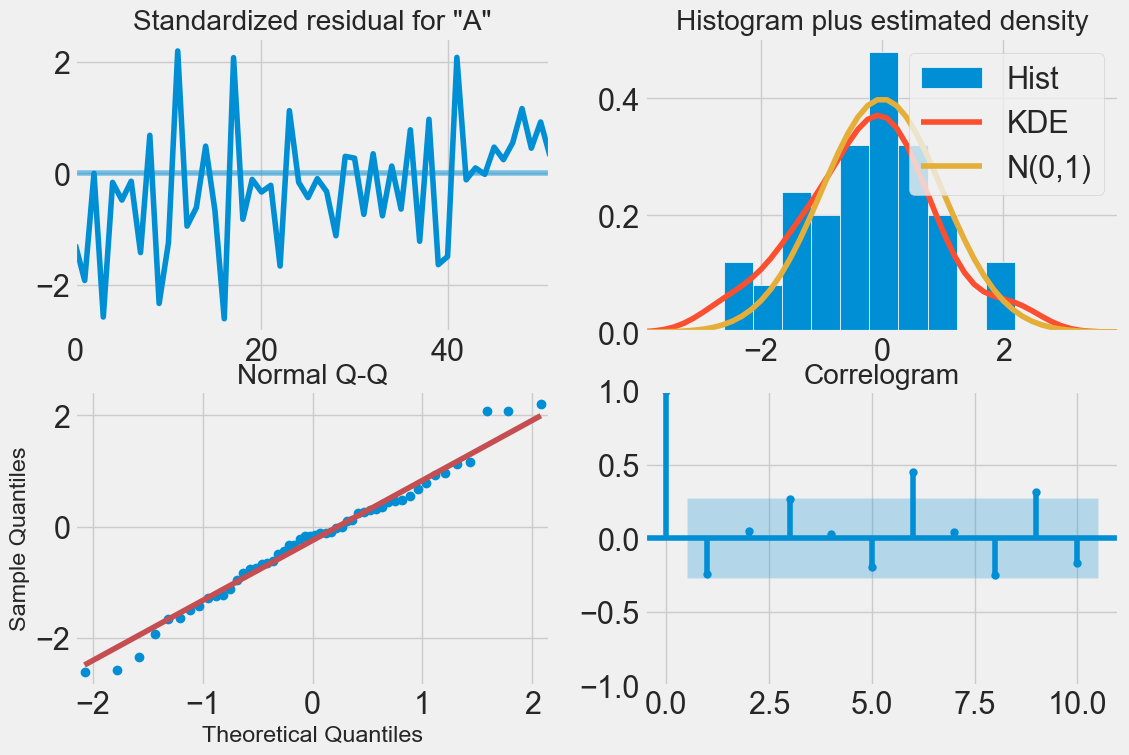

In [48]:
its_sarimax.plot_sarimax_params()


## 状態空間モデル

/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37629D+01    |proj g|=  5.97921D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   5.979D-07   1.376D+01
  F =   13.762902485088553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


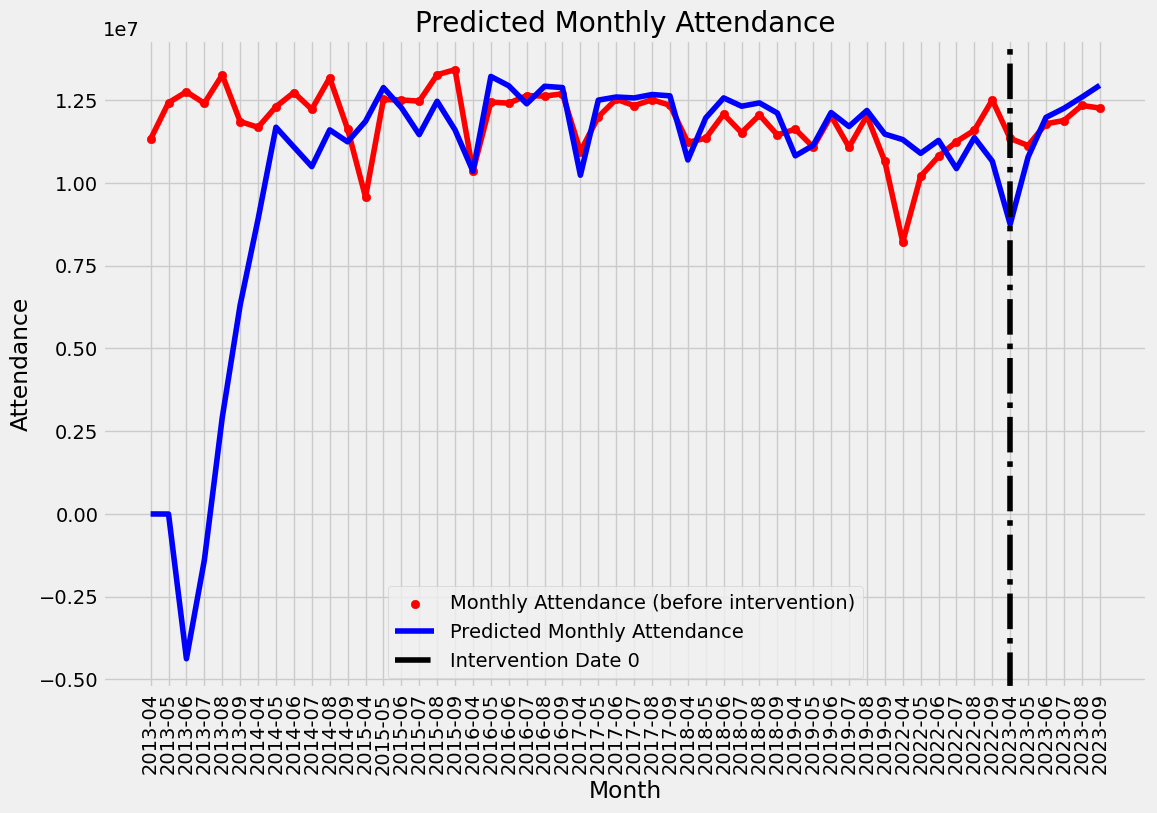

In [5]:
its_state_space = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='State Space Model')
its_state_space.plot_predict()

In [4]:
its_state_space.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Unobserved Components Results                            
====================================================================================
Dep. Variable:                   Attendance   No. Observations:                   54
Model:                          local level   Log Likelihood                -743.197
                   + stochastic seasonal(6)   AIC                           1498.393
Date:                      Sun, 12 Nov 2023   BIC                           1509.621
Time:                              21:48:43   HQIC                          1502.636
Sample:                                   0                                         
                                       - 54                                         
Covariance Type:                        opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular       6.533e+11   4.96e+11      1.316      0.188    -3.2e+11    1.63e+12
sigma2.level           1.434e+11   5.74e+10      2.496      0.013    3.08e+10    2.56e+11
sigma2.seasonal        6.533e+11   5.28e+11      1.238      0.216   -3.81e+11    1.69e+12
beta.time since start -1898.6808   1.19e+05     -0.016      0.987   -2.35e+05    2.31e+05
beta.level change 0   -3.328e+05   2.01e+06     -0.166      0.868   -4.27e+06     3.6e+06
beta.slope change 0    1.868e+05   1.03e+06      0.181      0.857   -1.84e+06    2.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.60   Jarque-Bera (JB):                 4.85
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               0.77   Skew:                             0.21
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 層別分析

## 曜日層別

In [2]:
holidays_df = pd.read_csv('./data/holidays_df.csv').set_index('Unnamed: 0')
holidays_df.index.name = None
holidays_df

,Attendance
2013-04,5705194
2013-05,6787296
2013-06,7147273
2013-07,6809910
2013-08,7187828
2013-09,6870757
2014-04,5847702
2014-05,7270233
2014-06,6713150
2014-07,6259649


In [5]:
#! layer=Trueで本来はやるべきだけど、やると都合の悪い結果が出てきます。
#! optim_params_sarimaxのobjective2()でseasonal項も最適化するようにしているので、それをいじれば元通り。
its_periodical_OLS = MITS(holidays_df, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, layer=True)
its_periodical_OLS.show_summary()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:723: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: divide by zero encountered in divide
  np.inner(score_obs, score_obs) /
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: divide by zero encountered in divide
  np.inner(score_ob

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                 Attendance   No. Observations:                   54
Model:             SARIMAX(0, 1, 0)x(0, 2, [1, 2, 3], 11)   Log Likelihood                -500.649
Date:                                    Mon, 18 Dec 2023   AIC                           1015.297
Time:                                            15:57:01   BIC                           1025.335
Sample:                                                 0   HQIC                          1018.570
                                                     - 54                                         
Covariance Type:                                      opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0 -6.009e+05   2.88e+07     -0.021      0.983    -5.7e+07    5.58e+07
slope change 0 -2.065e+05    5.5e+06     -0.038      0.970    -1.1e+07    1.06e+07
pulse1         -2.289e+06   3.96e+06     -0.577      0.564   -1.01e+07    5.48e+06
ma.S.L11          -1.1713      1.825     -0.642      0.521      -4.748       2.406
ma.S.L22           0.7668      3.657      0.210      0.834      -6.401       7.934
ma.S.L33          -0.2753      6.284     -0.044      0.965     -12.592      12.041
sigma2          1.325e+13     31.818   4.16e+11      0.000    1.32e+13    1.32e+13
===================================================================================
Ljung-Box (L1) (Q):                  13.24   Jarque-Bera (JB):                 2.24
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.34   Skew:                            -0.65
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+27. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:872: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting pa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51533D+00    |proj g|=  5.32181D-01


 This problem is unconstrained.



At iterate    5    f=  9.26964D+00    |proj g|=  1.00400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8      9      1     0     0   1.347D-06   9.270D+00
  F =   9.2696415148791935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


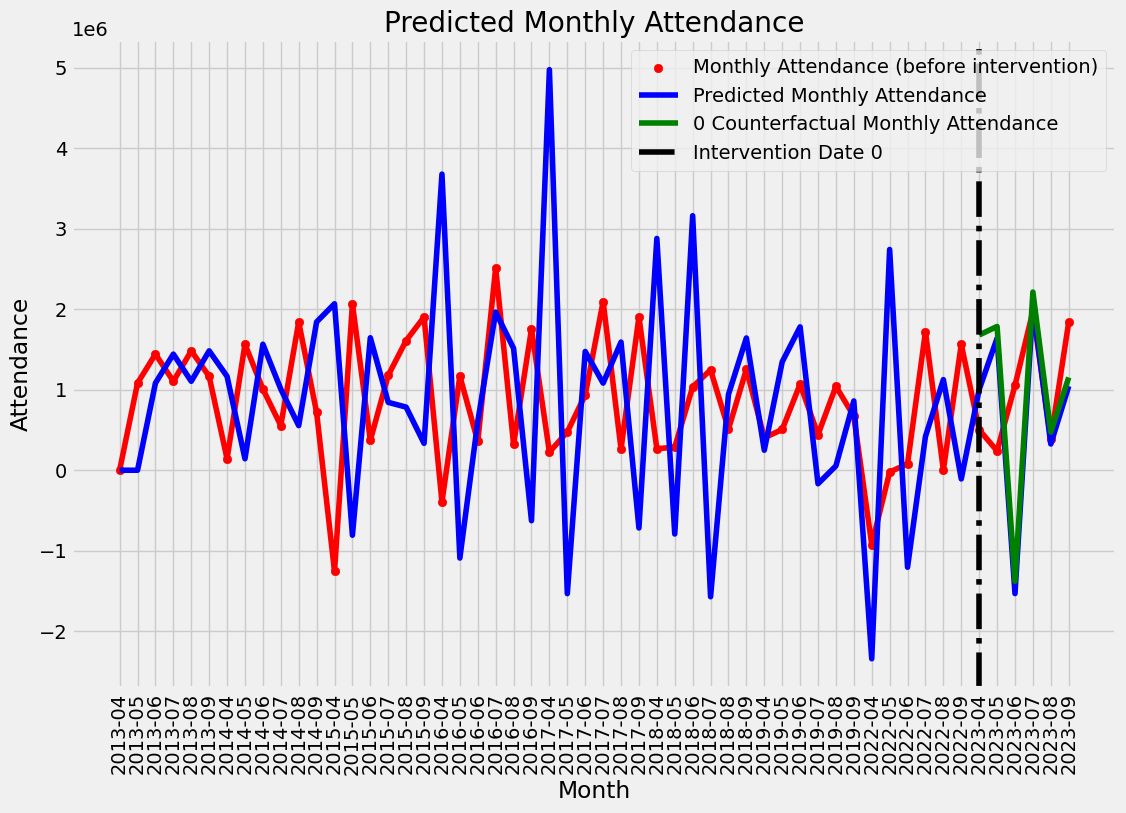

In [82]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [12]:
non_holidays_df = pd.read_csv('./data/non_holidays_df.csv').set_index('Unnamed: 0')
non_holidays_df.index.name = None
non_holidays_df

,Attendance
2013-04,5621967
2013-05,5636581
2013-06,5606207
2013-07,5596962
2013-08,6074109
2013-09,4984146
2014-04,5832450
2014-05,5032112
2014-06,6018309
2014-07,5964121


In [15]:
its_periodical_OLS = MITS(non_holidays_df, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7, layer=False)
its_periodical_OLS.show_summary()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:723: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/version

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(2, 2, 3)x(0, 2, 3, 6)   Log Likelihood                -608.216
Date:                           Mon, 18 Dec 2023   AIC                           1238.432
Time:                                   04:28:26   BIC                           1257.010
Sample:                                        0   HQIC                          1245.149
                                            - 54                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0  5.389e+06   2.53e-07   2.13e+13      0.000    5.39e+06    5.39e+06
slope change 0 -2.796e+06   2.42e-07  -1.15e+13      0.000    -2.8e+06    -2.8e+06
ar.L1             -1.3766      0.069    -20.015      0.000      -1.511      -1.242
ar.L2             -1.0000      0.060    -16.693      0.000      -1.117      -0.883
ma.L1              0.6785      0.305      2.225      0.026       0.081       1.276
ma.L2              0.0011      0.538      0.002      0.998      -1.053       1.055
ma.L3             -0.6106      0.294     -2.079      0.038      -1.186      -0.035
ma.S.L6           -0.6578      0.570     -1.155      0.248      -1.774       0.458
ma.S.L12          -0.1077      0.715     -0.151      0.880      -1.510       1.295
ma.S.L18           0.1648      0.820      0.201      0.841      -1.442       1.772
sigma2          1.356e+12    5.3e-13   2.56e+24      0.000    1.36e+12    1.36e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 9.19
Prob(Q):                              0.77   Prob(JB):                         0.01
Heteroskedasticity (H):               5.03   Skew:                             0.90
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+40. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:872: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting pa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13918D+01    |proj g|=  2.60226D-01

At iterate    5    f=  1.12368D+01    |proj g|=  3.66525D-02

At iterate   10    f=  1.12221D+01    |proj g|=  4.16243D-03

At iterate   15    f=  1.12201D+01    |proj g|=  6.74055D-03

At iterate   20    f=  1.12196D+01    |proj g|=  1.82541D-03

At iterate   25    f=  1.12196D+01    |proj g|=  8.44942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     30      1     0     0   

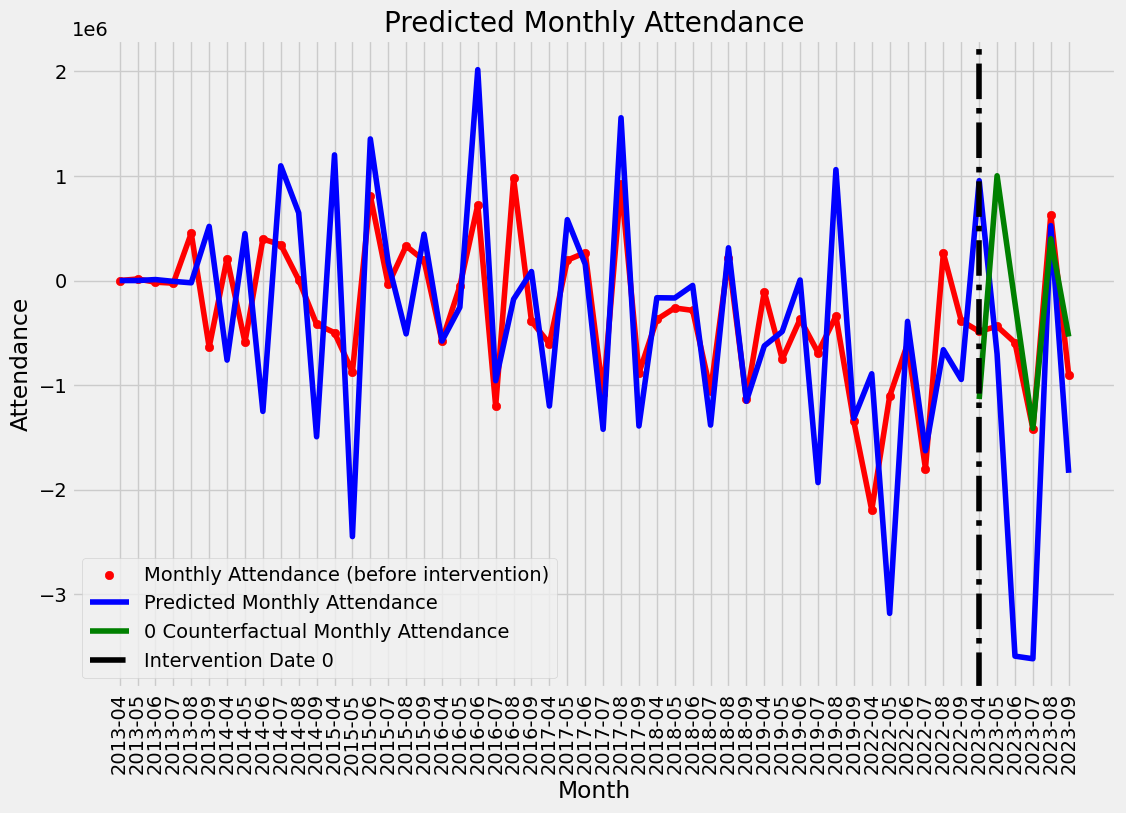

In [16]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

## 人気球団別

In [2]:
popular_typeA_df = pd.read_csv('./data/popular_teams_typeA.csv').set_index('Unnamed: 0')
popular_typeA_df.index.name = None
popular_typeA_df

popular_typeB_df = pd.read_csv('./data/popular_teams_typeB.csv').set_index('Unnamed: 0')
popular_typeB_df.index.name = None
popular_typeB_df

unpopular_df = pd.read_csv('./data/unpopular_teams.csv').set_index('Unnamed: 0')
unpopular_df.index.name = None
unpopular_df

,Attendance
2013-04,847968
2013-05,666626
2013-06,836011
2013-07,802564
2013-08,959578
2013-09,793177
2014-04,777560
2014-05,852133
2014-06,926360
2014-07,786134


In [3]:
its_periodical_OLS = MITS(popular_typeA_df, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7, layer=False)
its_periodical_OLS.show_summary()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:723: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/version

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(2, 2, 3)x(0, 2, 3, 6)   Log Likelihood                -571.310
Date:                           Mon, 18 Dec 2023   AIC                           1164.620
Time:                                   04:18:36   BIC                           1183.197
Sample:                                        0   HQIC                          1171.337
                                            - 54                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0  5.838e+05   7.02e+05      0.832      0.405   -7.92e+05    1.96e+06
slope change 0 -9.562e+05   2.95e+05     -3.244      0.001   -1.53e+06   -3.78e+05
ar.L1             -0.9385      1.306     -0.718      0.473      -3.499       1.622
ar.L2             -0.0267      0.894     -0.030      0.976      -1.779       1.725
ma.L1             -0.4369      1.416     -0.309      0.758      -3.211       2.338
ma.L2             -0.4653      2.032     -0.229      0.819      -4.447       3.517
ma.L3              0.8245      1.192      0.692      0.489      -1.511       3.161
ma.S.L6           -0.9481      0.917     -1.033      0.301      -2.746       0.850
ma.S.L12          -0.0860      1.318     -0.065      0.948      -2.669       2.497
ma.S.L18           0.3033      0.898      0.338      0.736      -1.457       2.063
sigma2          2.404e+11      0.434   5.54e+11      0.000     2.4e+11     2.4e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.86   Prob(JB):                         0.83
Heteroskedasticity (H):               3.15   Skew:                            -0.24
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.56e+27. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:872: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting pa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05740D+01    |proj g|=  1.70607D-01

At iterate    5    f=  1.04534D+01    |proj g|=  1.20991D-02

At iterate   10    f=  1.04473D+01    |proj g|=  5.36277D-03

At iterate   15    f=  1.04469D+01    |proj g|=  1.24197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     19     21      1     0     0   5.692D-06   1.045D+01
  F =   10.446866112992447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


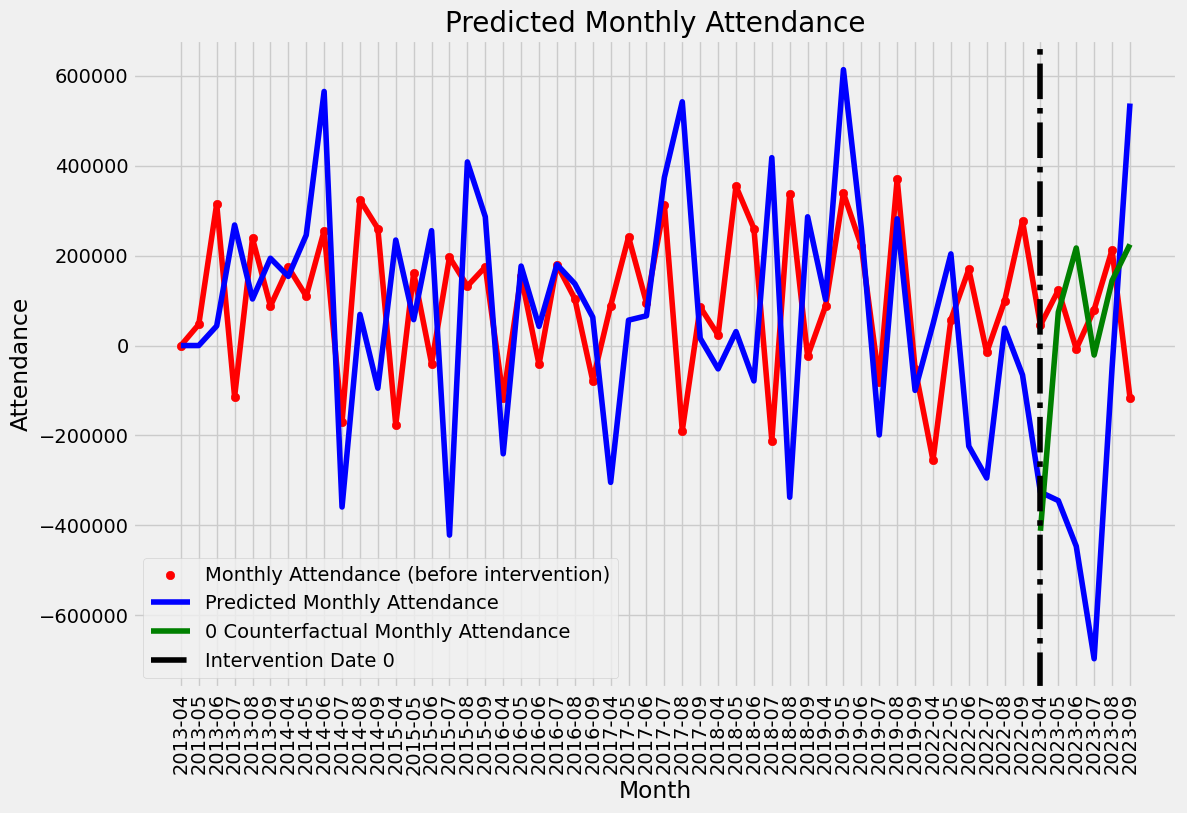

In [4]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [5]:
its_periodical_OLS = MITS(popular_typeB_df, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7, layer=False)
its_periodical_OLS.show_summary()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:723: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/version

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 6)   Log Likelihood                -572.273
Date:                           Mon, 18 Dec 2023   AIC                           1162.547
Time:                                   04:19:52   BIC                           1177.746
Sample:                                        0   HQIC                          1168.042
                                            - 54                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0  1.367e+06   9.76e+05      1.400      0.161   -5.46e+05    3.28e+06
slope change 0 -1.265e+06   4.37e+05     -2.893      0.004   -2.12e+06   -4.08e+05
ar.L1              0.9493      0.304      3.121      0.002       0.353       1.545
ar.L2              0.0035      0.343      0.010      0.992      -0.668       0.675
ma.L1             -1.8004      0.380     -4.736      0.000      -2.545      -1.055
ma.L2              0.9632      0.415      2.321      0.020       0.150       1.776
ma.S.L6           -1.1742      0.466     -2.517      0.012      -2.088      -0.260
ma.S.L12           0.2931      0.323      0.906      0.365      -0.341       0.927
sigma2          1.805e+11      0.455   3.97e+11      0.000     1.8e+11     1.8e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.77   Prob(JB):                         0.19
Heteroskedasticity (H):               1.39   Skew:                             0.71
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.73e+27. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:872: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11360D+01    |proj g|=  1.25239D+00

At iterate    5    f=  1.04525D+01    |proj g|=  6.52661D-03

At iterate   10    f=  1.04514D+01    |proj g|=  3.69899D-03
  ys=-6.525E-03  -gs= 2.791E-03 BFGS update SKIPPED


 This problem is unconstrained.



At iterate   15    f=  1.04300D+01    |proj g|=  1.37819D-02

At iterate   20    f=  1.04159D+01    |proj g|=  1.30384D-02

At iterate   25    f=  1.04144D+01    |proj g|=  1.61249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     37      1     1     0   4.452D-06   1.041D+01
  F =   10.414429241166035     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


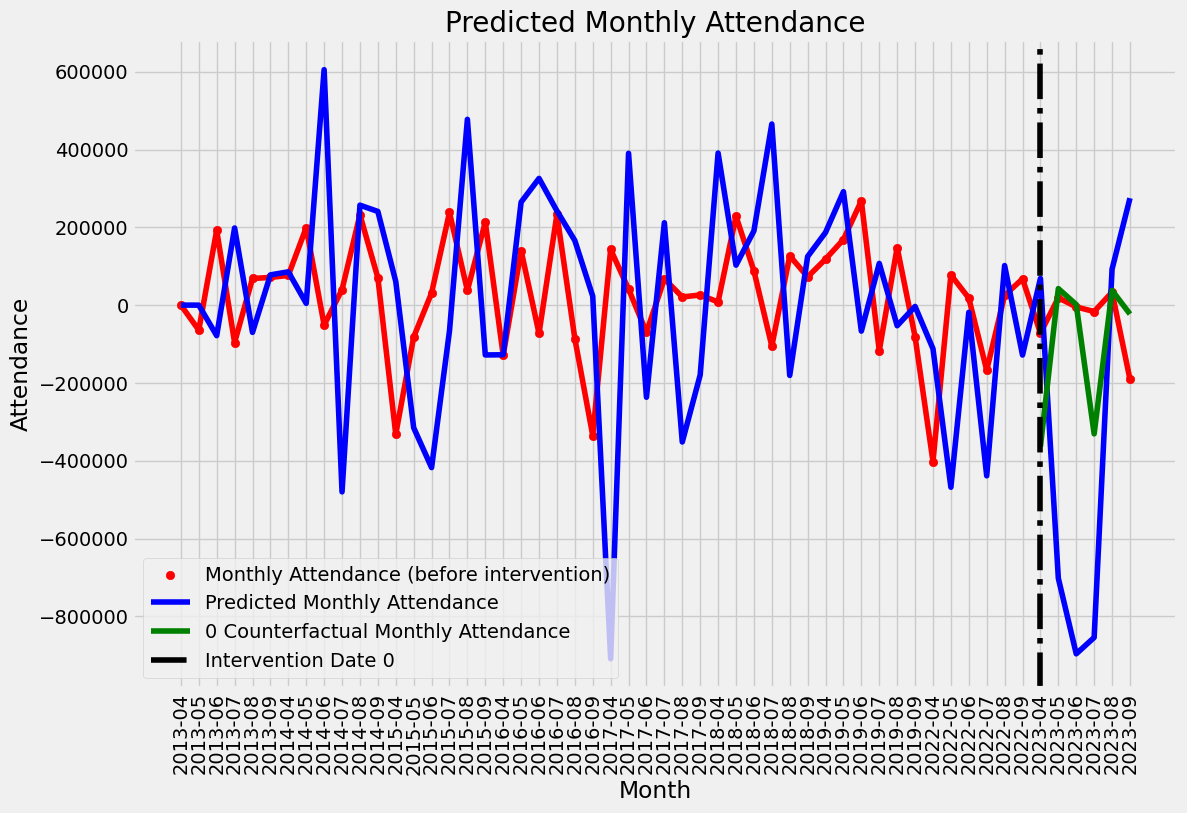

In [6]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [7]:
its_periodical_OLS = MITS(unpopular_df, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7, layer=False)
its_periodical_OLS.show_summary()

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:723: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.df_sarimax['Attendance'] = self.df_sarimax['Attendance'] - self.df_sarimax['Attendance'][0]
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/version

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Attendance   No. Observations:                   54
Model:             SARIMAX(3, 2, 2)x(3, 2, [], 6)   Log Likelihood                -525.691
Date:                            Mon, 18 Dec 2023   AIC                           1073.381
Time:                                    04:22:01   BIC                           1091.959
Sample:                                         0   HQIC                          1080.098
                                             - 54                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
level change 0  2.217e+05   2.57e+05      0.863      0.388   -2.82e+05    7.25e+05
slope change 0 -9.979e+04   1.54e+05     -0.649      0.517   -4.01e+05    2.02e+05
ar.L1             -0.8366      4.462     -0.187      0.851      -9.582       7.909
ar.L2             -0.1462      1.845     -0.079      0.937      -3.763       3.471
ar.L3              0.0891      0.880      0.101      0.919      -1.635       1.814
ma.L1             -0.3954      4.424     -0.089      0.929      -9.066       8.275
ma.L2             -0.4668      3.849     -0.121      0.903      -8.011       7.077
ar.S.L6           -0.9691      0.523     -1.854      0.064      -1.994       0.055
ar.S.L12          -0.5018      0.616     -0.814      0.415      -1.709       0.706
ar.S.L18          -0.1458      0.515     -0.283      0.777      -1.155       0.863
sigma2          2.609e+10      1.350   1.93e+10      0.000    2.61e+10    2.61e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.55
Prob(Q):                              0.94   Prob(JB):                         0.17
Heteroskedasticity (H):               1.28   Skew:                             0.49
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.07e+26. Standard errors may be unstable.
"""

/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:872: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red')
/Users/mototsuguohki/Desktop/研究室/卒業研究/InterruptedTimeSeries.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(self.df.index, self.df['Attendance']-self.df['Attendance'][0], color='red', label='Monthly Attendance (before intervention)')
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive param

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01720D+01    |proj g|=  7.68108D-01

At iterate    5    f=  9.74014D+00    |proj g|=  2.94039D-02

At iterate   10    f=  9.73302D+00    |proj g|=  2.12526D-03

At iterate   15    f=  9.73298D+00    |proj g|=  4.32591D-04

At iterate   20    f=  9.73296D+00    |proj g|=  5.57900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     21     23      1     0     0   2.977D-05   9.733D+00
  F =   9.7329647538788642     

CONVERG

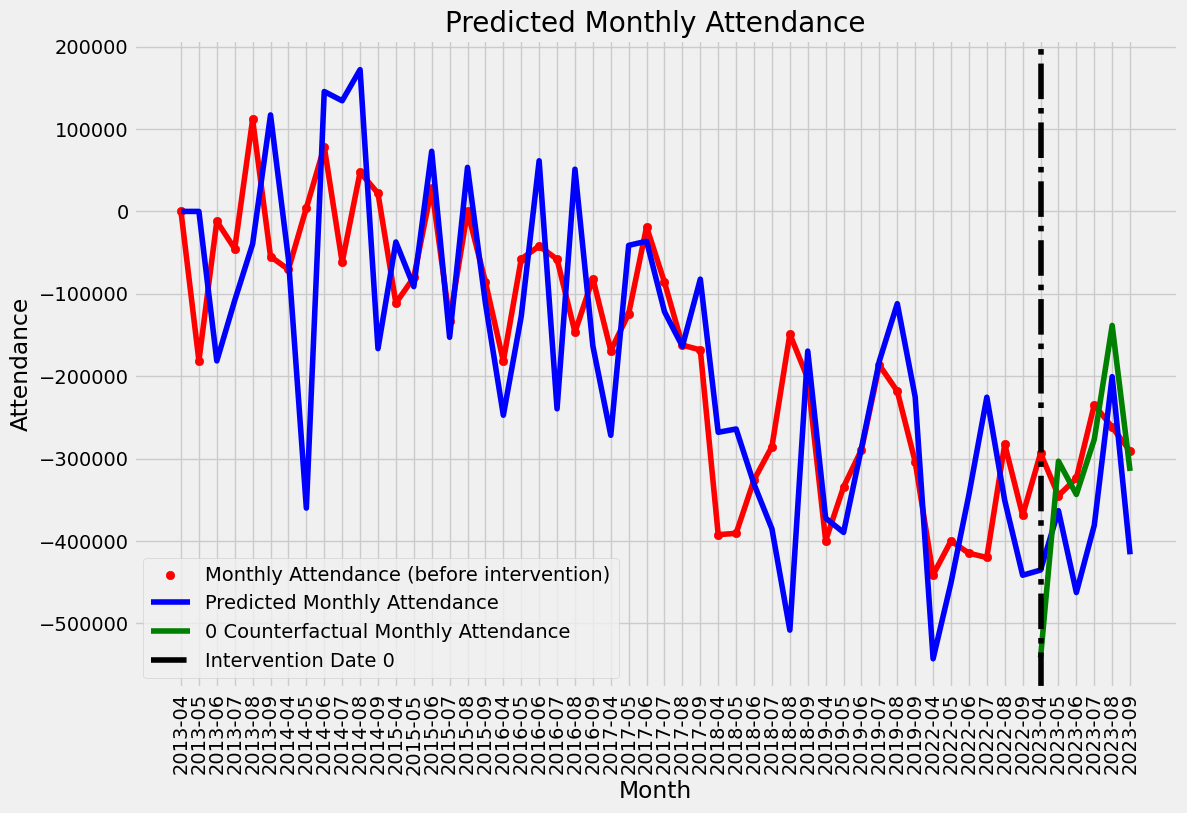

In [8]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

# ベイズ

In [60]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier='with_predict')
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()
df_att_remove_covid_addup

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29988D+01    |proj g|=  2.06281D+00

At iterate    5    f=  1.23400D+01    |proj g|=  1.28532D-01

At iterate   10    f=  1.22608D+01    |proj g|=  9.35530D-02

At iterate   15    f=  1.22243D+01    |proj g|=  1.57222D-01

At iterate   20    f=  1.22021D+01    |proj g|=  1.08947D-01

At iterate   25    f=  1.22013D+01    |proj g|=  6.39626D-03

At iterate   30    f=  1.22006D+01    |proj g|=  1.02883D-01

At iterate   35    f=  1.21992D+01    |proj g|=  2.35841D-02

At iterate   40    f=  1.21986D+01    |proj g|=  7.89498D-03

At iterate   45    f=  1.21969D+01    |proj g|=  6.38762D-03

At iterate   50    f=  1.21951D+01    |proj g|=  1.73677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Attendance
2013-04,11327161
2013-05,12423877
2013-06,12753480
2013-07,12406872
2013-08,13261937
2013-09,11854903
2014-04,11680152
2014-05,12302345
2014-06,12731459
2014-07,12223770


In [61]:
# df_att_remove_covid_addupのAttendanceの各月の値から最初の月を引く
df_att_remove_covid_addup['Attendance'] = df_att_remove_covid_addup['Attendance'] - df_att_remove_covid_addup['Attendance'][0]
df_att_remove_covid_addup

/var/folders/yq/lx5qv2_9299_1q6b2jtwqzn40000gn/T/ipykernel_67654/1100984118.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_att_remove_covid_addup['Attendance'] = df_att_remove_covid_addup['Attendance'] - df_att_remove_covid_addup['Attendance'][0]


,Attendance
2013-04,0
2013-05,1096716
2013-06,1426319
2013-07,1079711
2013-08,1934776
2013-09,527742
2014-04,352991
2014-05,975184
2014-06,1404298
2014-07,896609


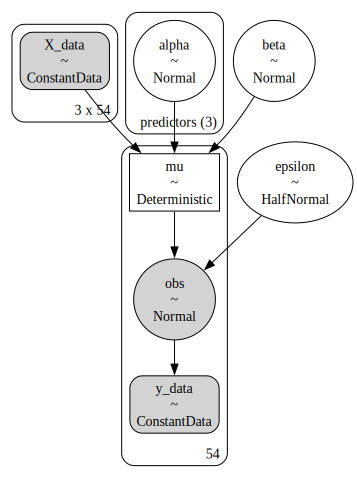

In [62]:
import pymc as pm
import arviz as az


# データの読み込み
intervention_date = '2023-04'
data = df_att_remove_covid_addup
# 介入の列を追加
data['level change'] = [1 if date >= intervention_date else 0 for date in data.index]
data['index'] = [i for i in range(len(data))]
# 介入のインデックス
intervention_index = data['index'][data[data['level change'] == 1].index[0]]
# 介入前は0, 介入の後、1ずつ増える変数
data['slope change'] = [0 if date < intervention_date else i - intervention_index for i, date in enumerate(data.index)]
X = data[['index', 'level change', 'slope change']]
y = data['Attendance'].values
# display(X)
columns = X.columns.values
# 中断時系列分析の実施
model1 = pm.Model(coords={'predictors': columns}) # モデルコンテキスト内で、predictorsという名前で項目名のリストを使えるようになる。
with model1:
    # パラメータの設定
    X_data = pm.ConstantData('X_data', X.T)
    
    y_data = pm.ConstantData('y_data', y)
    # 介入のタイミング（ここでは仮に2023年4月と設定）
    alpha = pm.Normal('alpha', mu=0, sigma=100, dims='predictors')

    beta = pm.Normal('beta', mu=100.0, sigma=25.0)
    epsilon = pm.HalfNormal('epsilon', sigma=25.0)
    
    mu = pm.Deterministic('mu', alpha @ X_data + beta)
    
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model1)
display(g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


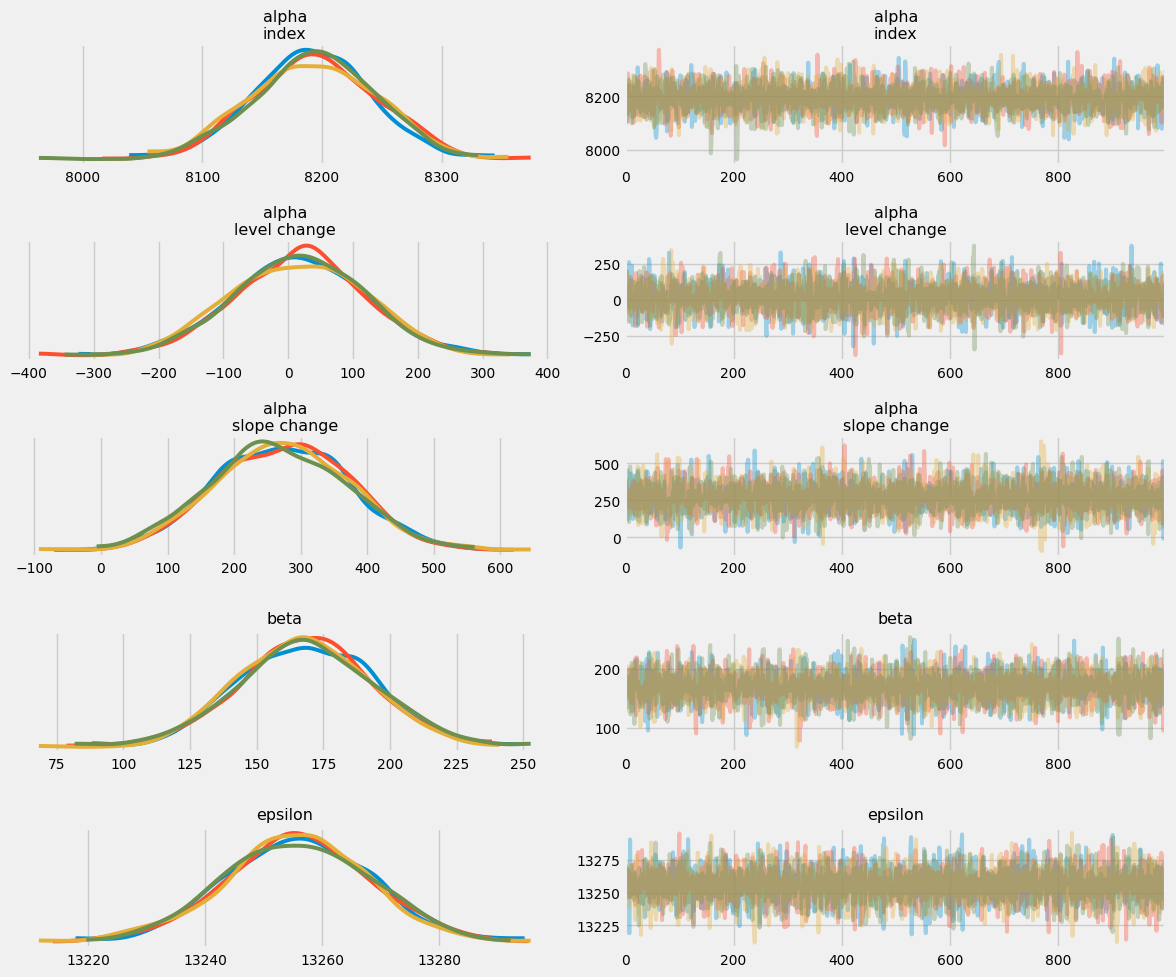

In [63]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.95)

az.plot_trace(idata1, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout()

In [64]:
summary1 = az.summary(idata1, var_names=['alpha'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[index],8193.282,51.312,8097.796,8284.574,0.685,0.484,5668.0,3083.0,1.01
alpha[level change],17.186,100.609,-172.788,200.716,1.300,1.643,5979.0,2921.0,1.00
alpha[slope change],271.552,101.413,74.946,449.290,1.262,1.007,6487.0,3014.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

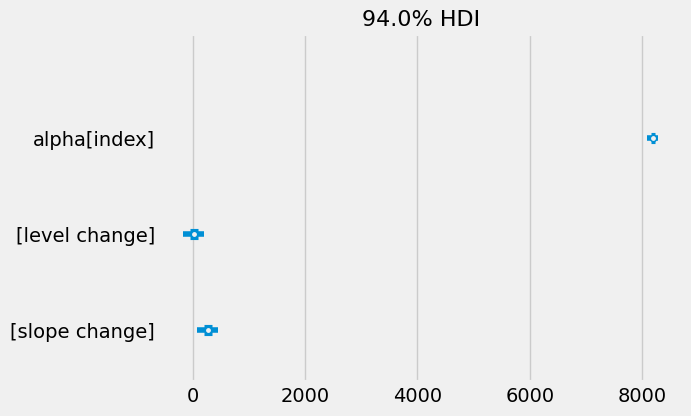

In [65]:
# 介入変数のみの94%信用区間を表示
az.plot_forest(idata1, var_names=['alpha'], combined=True)

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35251 (\N{CJK UNIFIED IDEOGRAPH-89B3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages

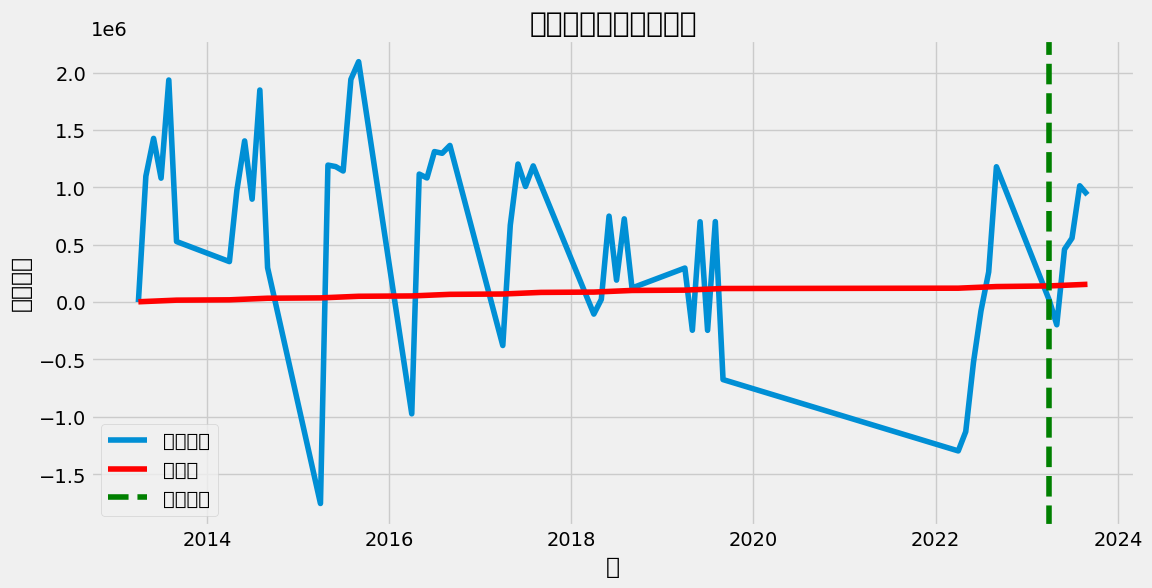

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# データの読み込み
data = df_att_remove_covid_addup
data.index = pd.to_datetime(data.index)  # インデックスを日付型に変換

# モデルからパラメータを取得
alpha_mean = idata1.posterior['alpha'].mean().values
beta1_mean = idata1.posterior['alpha'][:, 0].mean().values # level change
beta2_mean = idata1.posterior['alpha'][:, 1].mean().values # slope change
# 介入のタイミングを設定（例: 2023年4月）
intervention_time = pd.to_datetime('2023-04')

# 予測値の計算
pre_intervention = data.index < intervention_time
post_intervention = data.index >= intervention_time
expected_attendance = alpha_mean + beta1_mean * np.arange(len(data)) + beta2_mean * post_intervention

# プロット
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Attendance'], label='実データ')
plt.plot(data.index, expected_attendance, color='red', label='予測値')
plt.axvline(x=intervention_time, color='green', linestyle='--', label='介入時点')
plt.xlabel('月')
plt.ylabel('観客者数')
plt.title('中断時系列分析の結果')
plt.legend()
plt.show()


In [67]:
import numpy as np

with pm.Model() as cyclical_model:
    # パラメータ
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=2)  # sinおよびcos用の係数
    sigma = pm.HalfNormal('sigma', sigma=25)

    # 周期変数（例：年間周期）
    omega = 2 * np.pi / 12  # 月次データの場合
    x_cos = np.cos(omega * data['index'])
    x_sin = np.sin(omega * data['index'])

    # 期待値
    mu = alpha + beta[0] * x_cos + beta[1] * x_sin

    # 観測データとの関連付け
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=data['Attendance'])

    # サンプリング
    cyclical_trace = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


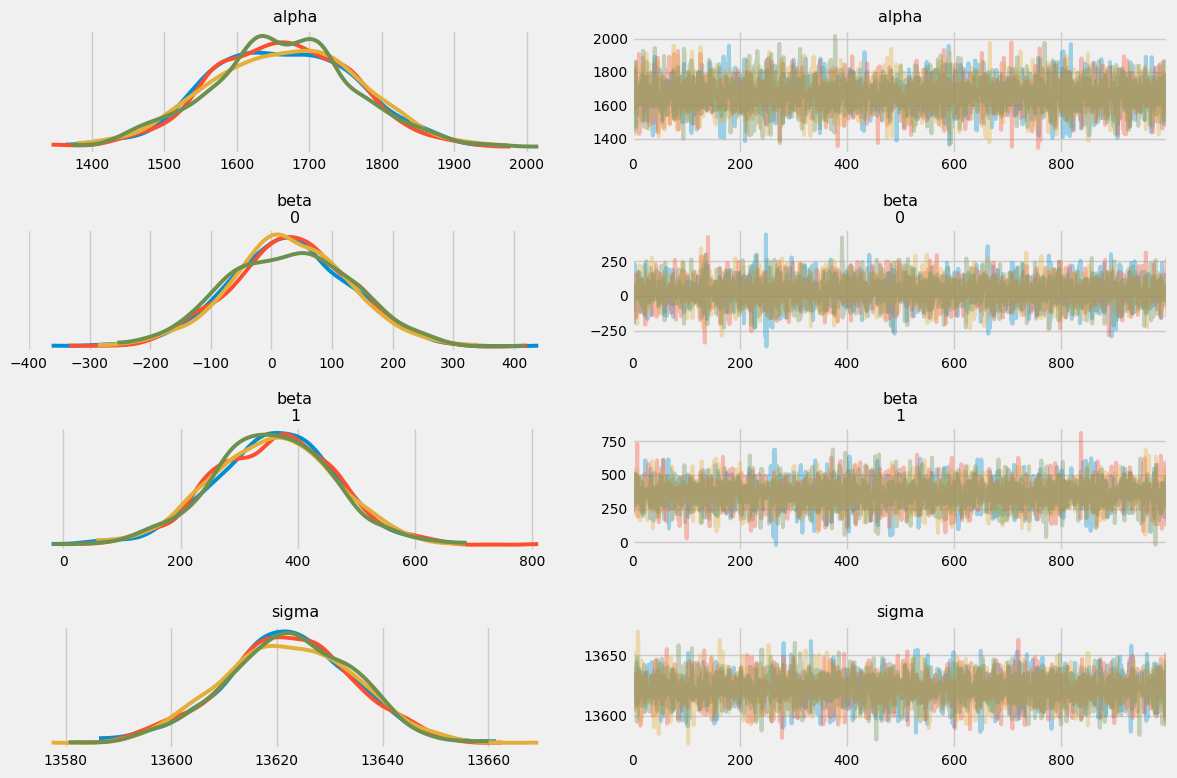

In [69]:
az.plot_trace(cyclical_trace, var_names=['alpha', 'beta', 'sigma'], compact=False)
plt.tight_layout()